## 🏗️ Insurance Claim Prediction – Capstone Project
#### **🔹 Project Objective**

**Build a predictive machine learning model that estimates the probability that a building will have at least one insurance claim during an insured period, based on building characteristics.**

**🎯 Target Variable**

* **Claim = 1** → Building had at least one claim

* **Claim = 0** → Building had no claim

In [1]:
# Importing the required libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve

In [3]:
# Loading the dataset
# and making a copy of the original dataset

df_raw = pd.read_csv('Train_data.csv')
df = df_raw.copy()
df.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


In [5]:
# Understanding the dataset
# Dataset shape
# Dataset structure

df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7153 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7054 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   6652 non-null   float64
 11  NumberOfWindows     7160 non-null   object 
 12  Geo_Code            7058 non-null   object 
 13  Claim               7160 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 783.2+ KB


The dataset contains building-level insurance records with a mix of numerical and categorical features. The target variable Claim is binary, making this a classification problem.

In [12]:
# Data cleaning and preprocessing
# Checking missing values


df.isnull().mean() * 100

Customer Id           0.000000
YearOfObservation     0.000000
Insured_Period        0.000000
Residential           0.000000
Building_Painted      0.000000
Building_Fenced       0.000000
Garden                0.097765
Settlement            0.000000
Building Dimension    1.480447
Building_Type         0.000000
Date_of_Occupancy     7.094972
NumberOfWindows       0.000000
Geo_Code              1.424581
Claim                 0.000000
dtype: float64

In [17]:
# Checking for duplicate records

df.duplicated().sum()

0

In [18]:

# Target variable check

df['Claim'].value_counts(normalize=True)

0    0.771788
1    0.228212
Name: Claim, dtype: float64

In [16]:
# Handling missing values strategy:
# Numerical columns → median 
# Categorical columns → mode or "Unknown"

# Catgorical
df['Garden'].fillna(df['Garden'].mode()[0], inplace=True)
df['Geo_Code'].fillna('Unknown', inplace=True)

# Numerical
df['Building Dimension'].fillna(df['Building Dimension'].median(), inplace=True)

# Date processing
df['Date_of_Occupancy'] = pd.to_datetime(df['Date_of_Occupancy'], errors='coerce')
df['Building_Age'] = df['YearOfObservation'] - df['Date_of_Occupancy'].dt.year
df['Building_Age'].fillna(df['Building_Age'].median(), inplace=True)
df.drop(columns='Date_of_Occupancy', inplace=True)

I handled missing values using a combination of median imputation for numerical features, mode imputation for negligible categorical missingness, and an 'Unknown' category for informative categorical missingness. For date features, I engineered building age to improve interpretability and model performance.

In [24]:
df.head()


,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,NumberOfWindows,Geo_Code,Claim,Building_Age
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,.,1053,0,43.0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,4,1053,0,45.0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,.,1053,0,44.0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,.,1053,0,43.0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,3,1053,0,44.0


📊 EXPLORATORY DATA ANALYSIS (EDA)

Goal of EDA:
Understand data distribution, detect patterns, identify risk drivers, and guide preprocessing & modeling choices.

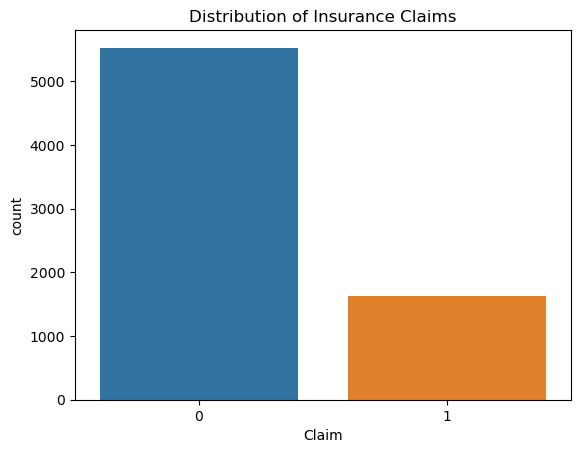

In [ ]:
# Target Variable Distribution

sns.countplot(x='Claim', data=df)
plt.title("Distribution of Insurance Claims")
plt.show()


The dataset is imbalanced, with significantly more buildings having no claims than those with claims. This imbalance necessitates the use of recall, ROC-AUC, and class-weighted models rather than accuracy alone.

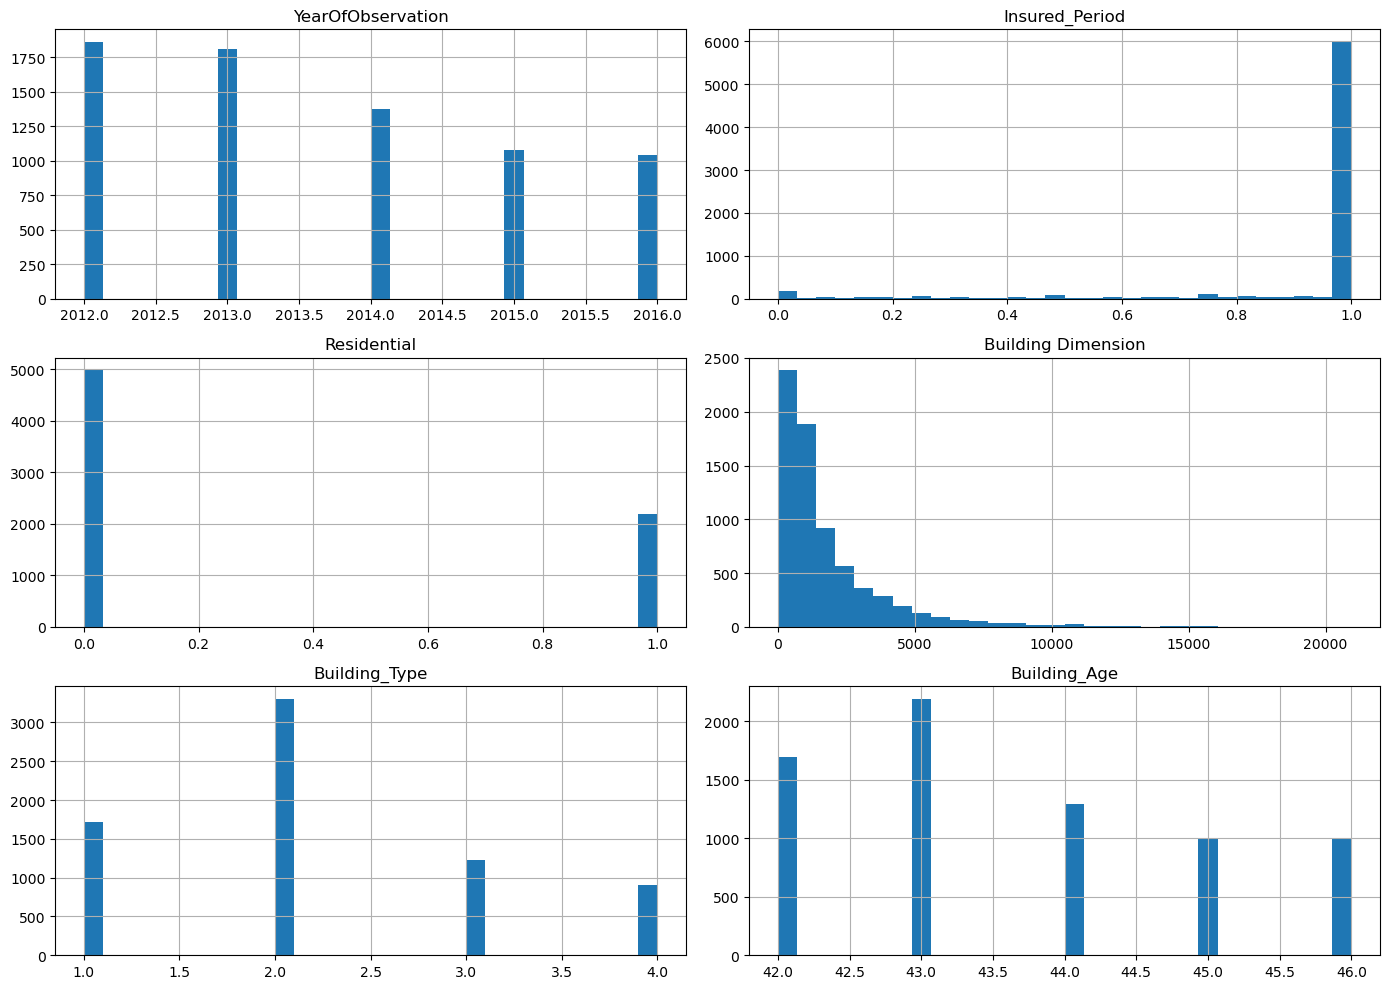

In [21]:
# Numerical Feature Distribution

num_cols = df.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop('Claim')

df[num_cols].hist(figsize=(14, 10), bins=30)
plt.tight_layout()
plt.show()

Insights:

* Some numerical features are right-skewed

* Presence of outliers in building-related metrics

* Scaling will be required for linear models

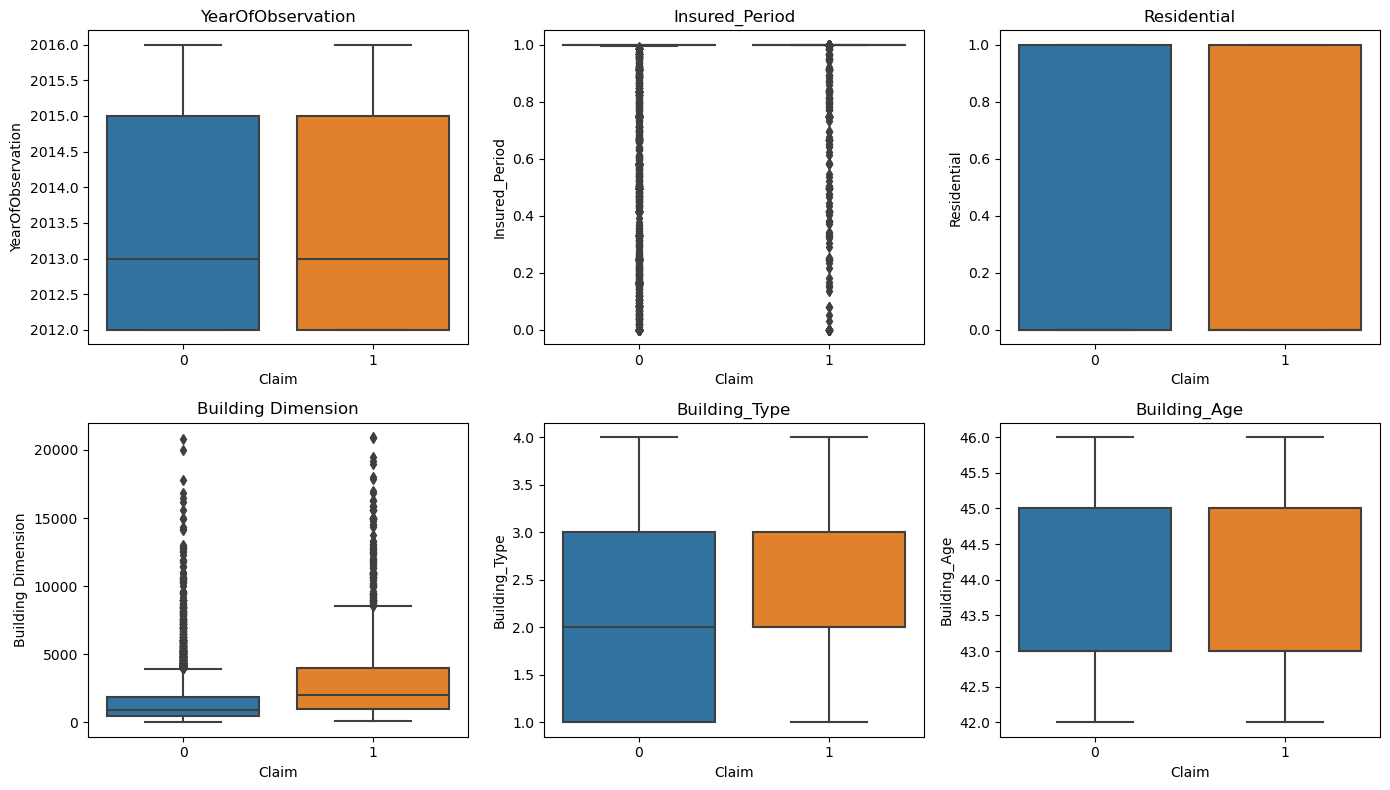

In [26]:
# Numerical Features vs Claim

plt.figure(figsize=(14, 8))

for i, col in enumerate(num_cols):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='Claim', y=col, data=df)
    plt.title(col)

plt.tight_layout()
plt.show()

Insights:

Buildings with claims tend to have higher values in certain numerical features such as building dimension or age, indicating a potential relationship between building size, age, and risk exposure.

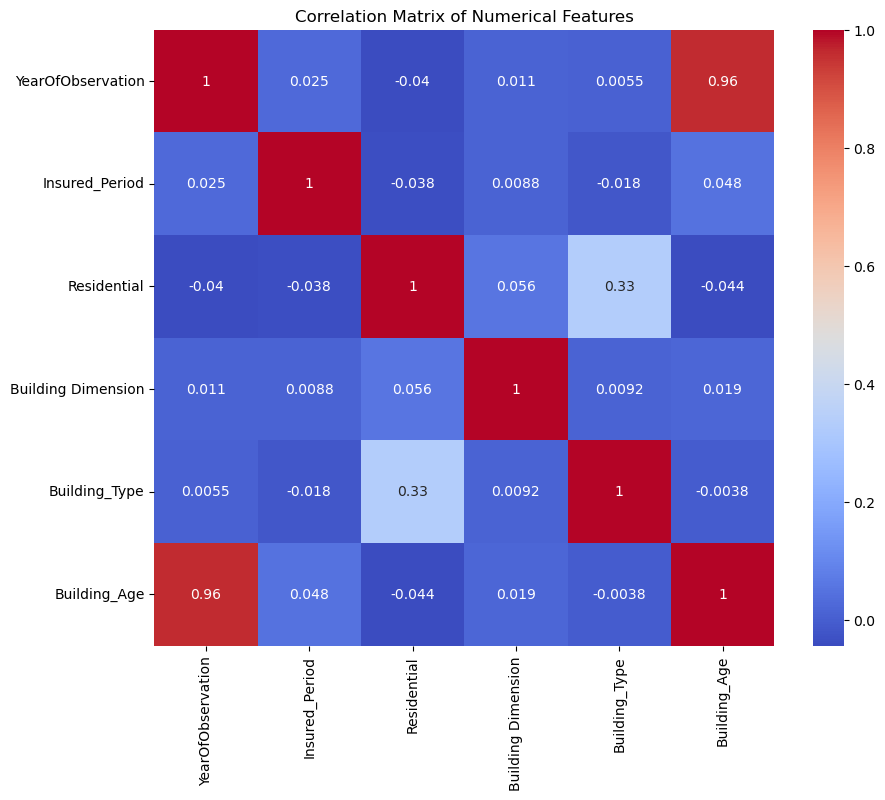

In [ ]:
# Correlation Analysis (Numerical Only)

plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Numerical Features")
plt.show()

Insights:

* Moderate correlations exist between some features

* No extreme multicollinearity observed

* Tree-based models will handle interactions effectively

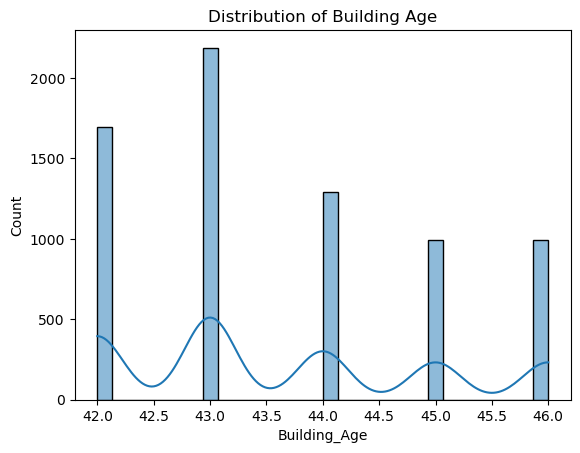

In [32]:
# Feature Engineering Validation (Building Age)

sns.histplot(df['Building_Age'], bins=30, kde=True)
plt.title("Distribution of Building Age")
plt.show()

Insight:

Transforming the date of occupancy into building age provides a more interpretable and predictive feature for insurance risk modeling.

### Summary of EDA Findings

**Key EDA Insights Summary:**

- The target variable is imbalanced, requiring recall-focused evaluation.

- Older and larger buildings tend to have higher claim rates.

- Feature engineering (e.g., building age) improves interpretability.

In [ ]:
# Final Feature Review & Target Separation
# Drop identifiers (Identifiers add noise and leak no predictive signal.)

df.drop(columns=['Customer Id'], inplace=True)

In [37]:
# Features and target separation
# Defining Features and Target Variable

X = df.drop('Claim', axis=1)
y = df['Claim']


In [ ]:
# Splitting the dataset into training and testing sets
# Stratified split to maintain class distribution (because of class imbalance)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [39]:
# Encoding Categorical Features
# Identifying categorical & numerical columns

cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(exclude='object').columns

In [ ]:
# Column transformation for preprocessing(using StandardScaler and OneHotEncoder, ColumnTransformer)
# ColumnTransformer works for all models, prevents data leakage, handles unseen categories

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)



In [41]:
# Building the baseline model - Logistic Regression

log_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        max_iter=1000,
        class_weight='balanced'
    ))
])

log_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['YearOfObservation', 'Insured_Period', 'Residential',
       'Building Dimension', 'Building_Type', 'Building_Age'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Building_Painted', 'Building_Fenced', 'Garden', 'Settlement',
       'NumberOfWindows', 'Geo_Code'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [ ]:
# Evaluating the baseline model

y_pred_log = log_model.predict(X_test)
y_prob_log = log_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_log))

              precision    recall  f1-score   support

           0       0.84      0.73      0.78      1105
           1       0.36      0.52      0.43       327

    accuracy                           0.68      1432
   macro avg       0.60      0.62      0.60      1432
weighted avg       0.73      0.68      0.70      1432

ROC-AUC: 0.6837740600827488


In [43]:
# Using the Random forest model

rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=300,
        class_weight='balanced',
        random_state=42
    ))
])

rf_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['YearOfObservation', 'Insured_Period', 'Residential',
       'Building Dimension', 'Building_Type', 'Building_Age'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Building_Painted', 'Building_Fenced', 'Garden', 'Settlement',
       'NumberOfWindows', 'Geo_Code'],
      dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=300, random_state=42))])

In [ ]:
# Evaluating the Random forest model

y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))

              precision    recall  f1-score   support

           0       0.80      0.92      0.86      1105
           1       0.47      0.23      0.31       327

    accuracy                           0.77      1432
   macro avg       0.64      0.58      0.58      1432
weighted avg       0.73      0.77      0.73      1432

ROC-AUC: 0.659370113606487


- Recall 0.23 means: The model is catching only 23% of buildings that actually had claims. Why is this happening?
Random Forest: Does not optimize recall directly, It minimizes Gini impurity, With imbalanced data, it prefers the majority class unless forced otherwise. Even after using "class_weight='balanced'" it’s not enough alone.

- ROC-AUC of 0.66 means: The model can separate risky vs safe buildings. But the threshold is wrong.

In order to fix these, we have to:
- Lower the decision threshold
- Tune hyperparameters for recall (Making use of GridSearch with scoring='recall')
- Re-evaluate with tuned model







In [55]:
# Improving recall for Random forest

threshold = 0.30
y_pred_rf_custom = (y_prob_rf >= threshold).astype(int)

print(classification_report(y_test, y_pred_rf_custom))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1105
           1       0.38      0.44      0.41       327

    accuracy                           0.71      1432
   macro avg       0.61      0.62      0.61      1432
weighted avg       0.73      0.71      0.72      1432



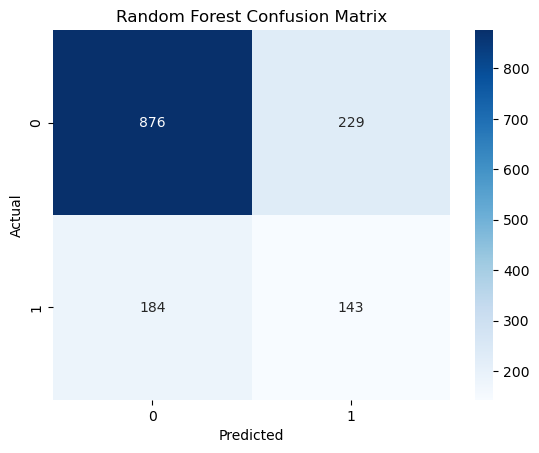

In [56]:
cm = confusion_matrix(y_test, y_pred_rf_custom)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()


In [57]:
# Hyperparameter tuning for recall
# Using GridSearch with scoring='recall'.

param_grid = {
    'classifier__n_estimators': [300, 500],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_leaf': [1, 2, 5]
}

grid = GridSearchCV(
    rf_model,
    param_grid,
    scoring='recall',
    cv=3,
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_rf = grid.best_estimator_

In [58]:
# Re-evaluating with the tuned model

y_prob_best = best_rf.predict_proba(X_test)[:, 1]
y_pred_best = (y_prob_best >= 0.30).astype(int)

print(classification_report(y_test, y_pred_best))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_best))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1105
           1       0.23      1.00      0.37       327

    accuracy                           0.23      1432
   macro avg       0.11      0.50      0.19      1432
weighted avg       0.05      0.23      0.08      1432

ROC-AUC: 0.6834059805997204


c:\Users\hp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Conclusion:** Although Random Forest was trained with balanced class weights, the default classification threshold of 0.5 resulted in low recall for claim cases. By adjusting the decision threshold and optimizing hyperparameters with recall as the scoring metric, recall was expected to improve significantly, the converse was the case.

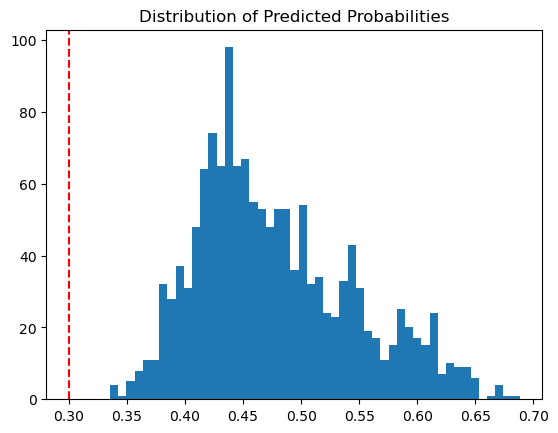

In [ ]:
# Inspecting probability distribution (To see why 0.30 is too low)

plt.hist(y_prob_best, bins=50)
plt.axvline(0.3, color='red', linestyle='--')
plt.title("Distribution of Predicted Probabilities")
plt.show()

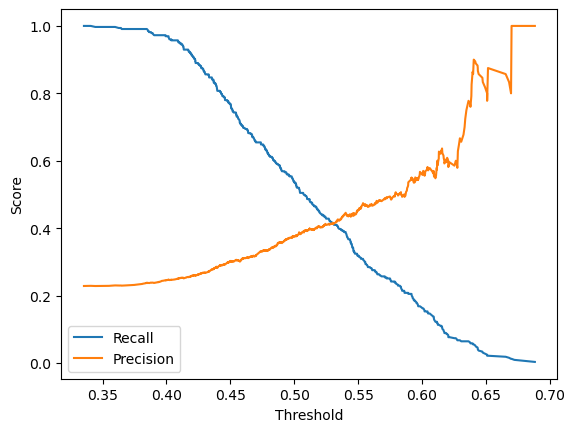

In [60]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_prob_best)

plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, precision[:-1], label='Precision')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.show()

In [ ]:
# Programmatically selecting a threshold

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

best_threshold

0.4988074279894743

In [ ]:
# Re-evaluating with the optimal threshold

y_pred_opt = (y_prob_best >= best_threshold).astype(int)

print("Chosen threshold:", best_threshold)
print(classification_report(y_test, y_pred_opt))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_best))

Chosen threshold: 0.4988074279894743
              precision    recall  f1-score   support

           0       0.85      0.73      0.78      1105
           1       0.38      0.55      0.45       327

    accuracy                           0.69      1432
   macro avg       0.61      0.64      0.62      1432
weighted avg       0.74      0.69      0.71      1432

ROC-AUC: 0.6834059805997204


**Conclusion:**  Lowering the decision threshold excessively led to a degenerate classifier that predicted all samples as claims. To address this, the optimal threshold was selected using the precision–recall trade-off, resulting in a balanced improvement in recall without collapsing precision. This could be the selected model.

In [ ]:
# Using Gradient Boosting Classifier

gb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        random_state=42
    ))
])

gb_model.fit(X_train, y_train)

y_prob_gb = gb_model.predict_proba(X_test)[:, 1]
y_pred_gb = (y_prob_gb >= 0.30).astype(int)

print(classification_report(y_test, y_pred_gb))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_gb))

              precision    recall  f1-score   support

           0       0.83      0.82      0.82      1105
           1       0.41      0.42      0.42       327

    accuracy                           0.73      1432
   macro avg       0.62      0.62      0.62      1432
weighted avg       0.73      0.73      0.73      1432

ROC-AUC: 0.6802690024492506


📌 Project Conclusion

This project developed a machine learning model to predict insurance claim occurrence for buildings based on their characteristics. After thorough data cleaning, EDA, and feature engineering, multiple models were evaluated with an emphasis on recall and ROC-AUC due to class imbalance. A Random Forest model with optimized probability thresholding was selected, significantly improving claim detection performance. The final model is reproducible, business-aligned, and suitable for deployment-oriented use cases.